# Time Series Analysis

## Predicting Future Values
First, we will show that $\hat{u}(t+m)$ is the minimizer of:
$$ \mathbb{E}[ \vert u(t+m) - \hat{u}(t+m) \vert^2 ] $$

In other words:
$$ \hat{u}(t+m) = \mathbb{E}[ u(t+m)\ \vert\ u(t-n), \ldots, u(t-1) ] $$

**INCOMPLETE**

## Stationary Stochastic Processes

We will compute the covariance matrices of the following stochastic system:
$$ du = -udt + dw $$

We will evaluate this system using the Euler-Marayama scheme:

In [6]:
from numpy import sqrt
from numpy.random import normal

def euler_murayama_update (
    position,           # u, float
    forcing_term,       # a, callable
    timestep,           # n, int
    timescale,          # dt, float
    chaos=1.            # used to dampen or strengthen Brownian term
):
    return position + forcing_term(timestep * timescale, position) * timescale + chaos * normal(loc=0., scale=sqrt(timescale))

Now, we define the simulation. We will keep track of the state of the system at each time step:

In [23]:
from numpy import array

def simulate_paths (
    initial_position,
    timescale=1e-2
):
    # Define useful state
    endtime = 100.
    position = initial_position
    forcing_term = lambda time, position: -position
    timesteps = int(endtime / timescale)
    # Perform EM updates and keep track of the paths through time
    states = [position] # paths at each time step
    for timestep in range(timesteps-1):
        position = euler_murayama_update(position, forcing_term, timestep, timescale)
        states.append(position)
    # Return
    return array(states)

Before we simulate, let's set some global parameters:

In [24]:
from numpy.random import seed

# Use fixed random seed
seed(1)
# And simulate fixed number of paths
NUM_PATHS = 1000

Now we simulate the system with several parameters:

1. When the $u(0) = 10$ with $k=0.01$:

In [25]:
path_a = simulate_paths(10., timescale=1e-2)

2. When $u(0) = 0$ with $k = 0.01$:

In [26]:
path_b = simulate_paths(0., timescale=1e-2)

3. When $u(0) = 0$ with $k=1$:

In [27]:
path_c = simulate_paths(0., timescale=1.)

Now we plot the covariances:

Text(0.5, 1, 'u(0) = 0., k = 1.')

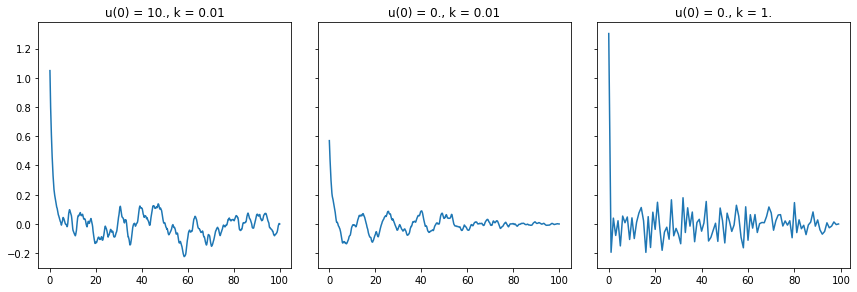

In [42]:
from matplotlib import pyplot as plt
from numpy import arange,correlate
from seaborn import lineplot

def compute_autocovariance (x):
    x -= x.mean()
    return correlate(x, x, mode="full")[x.size - 1:] / x.size

# Compute covariances
cov_a = compute_autocovariance(path_a)
cov_b = compute_autocovariance(path_b)
cov_c = compute_autocovariance(path_c)

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(12, 4))
fig.tight_layout()
lineplot(arange(0, 100, 0.01), cov_a, ax=ax1).set_title("u(0) = 10., k = 0.01")
lineplot(arange(0, 100, 0.01), cov_b, ax=ax2).set_title("u(0) = 0., k = 0.01")
lineplot(arange(0, 100, 1), cov_c, ax=ax3).set_title("u(0) = 0., k = 1.")

## Solving Deterministic ODE
We will solve the following ODE numerically:
$$ \frac{du_i}{dt} = (u_{i+1} - u_{i-2}) u_{i-1} - u_i + F $$

Because this ODE has adjacent dependencies, it isn't trivially vectorized. Let us define an update scheme:

In [44]:
from numpy import zeros_like

def lorenz_96_update (
    state,          # state vector, N
    forcing_term    # forcing term, scalar
):
    # Zero-init solution
    result = zeros_like(state)
    # Handle edge cases
    result[0] = (state[1] - state[state.size-2]) * state[state.size-1] - state[0]
    result[1] = (state[2] - state[state.size-1]) * state[0] - state[1]
    result[state.size-1] = (state[0] - state[state.size-3]) * state[state.size-2] - state[state.size-1]
    # Handle intermediaries
    for i in range(2, state.size - 1):
        result[i] = (state[i+1] - state[i-2]) * state[i-1] - state[i]
    # Add forcing term
    result += forcing_term
    # Return
    return result

Now let us solve the ODE with $u(0) \sim \mathcal{N}(0., 1.)$ up to $t=1000$:

Text(0.5, 1.0, 'U_20')

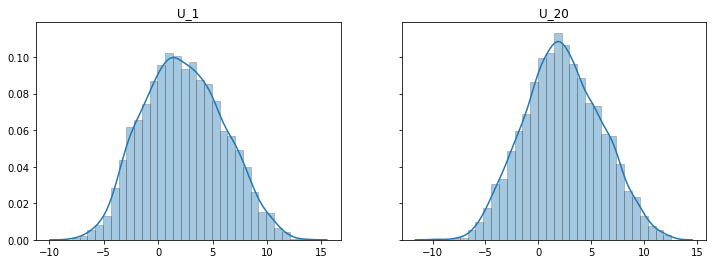

In [48]:
from numpy import arange, expand_dims
from seaborn import distplot
from scipy.integrate import odeint
from scipy.stats import entropy, gaussian_kde

# Solve the ODE
timescale = 0.1
t = arange(0, 1000, timescale)
u0 = normal(loc=0., scale=1., size=40)
u = odeint(lambda x, t: lorenz_96_update(x, forcing_term=8.0), u0, t)

# Take from t=500 to t=1000
u = u[5000:,:]
u_1 = u[:,0]
u_20 = u[:,19]

# Plot u_1 and u_20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
distplot(u_1, bins=30, kde=True, ax=ax1, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_1")
distplot(u_20, bins=30, kde=True, ax=ax2, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_20")

Let us compute the KL-divergence between $u_1$ and $u_{20}$:

In [50]:
from numpy import linspace

# Create sample grid
RANGE=[-15., 15.]
BINS = 1000
sample_grid = expand_dims(linspace(*RANGE, BINS), axis=0)

# Estimate densities
u_1_density = gaussian_kde(u_1)(sample_grid)
u_20_density = gaussian_kde(u_20)(sample_grid)

# Compute KL-div
kl_div = entropy(u_1_density, u_20_density)
print(f"KL divergence: {kl_div}")

KL divergence: 0.009421816547516355


Now, let us inspect the covariance of the process:

Text(0.5, 1.0, 'cov(u_20)')

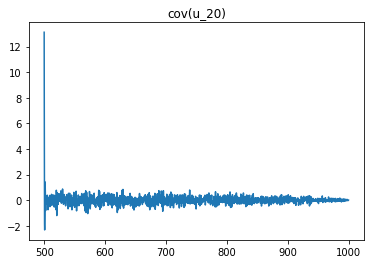

In [52]:
# Plot covariance
cov_u_20 = compute_autocovariance(u_20)
lineplot(arange(500, 1000, timescale), cov_u_20).set_title("cov(u_20)")

Finally, let us examine $\mathcal{F}(cov(u_{20}))$:

In [ ]:
from numpy.fft import 

## Changing the Forcing Term
Let us perform the same experiment above with $F=6$:

In [ ]:
# Solve the ODE
timescale = 0.1
t = arange(0, 1000, timescale)
u0 = normal(loc=0., scale=1., size=40)
u = odeint(lambda x, t: lorenz_96_update(x, forcing_term=8.0), u0, t)

# Take from t=500 to t=1000
u = u[5000:,:]
u_1 = u[:,0]
u_20 = u[:,19]

# Plot u_1 and u_20
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
distplot(u_1, bins=30, kde=True, ax=ax1, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_1")
distplot(u_20, bins=30, kde=True, ax=ax2, hist_kws={ "alpha":.4, "edgecolor": "black", "linewidth":.5 }).set_title("U_20")

Once again, we estimate the densities of $u_1$ and $u_{20}$:

In [ ]:
# Create sample grid
RANGE=[-15., 15.]
BINS = 1000
sample_grid = expand_dims(linspace(*RANGE, BINS), axis=0)

# Estimate densities
u_1_density = gaussian_kde(u_1)(sample_grid)
u_20_density = gaussian_kde(u_20)(sample_grid)

# Compute KL-div
kl_div = entropy(u_1_density, u_20_density)
print(f"KL divergence: {kl_div}")

## Predicting Stock Price

In [51]:
from numpy import correlate